In [1]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../../pySEMP/')
from scipy.optimize import curve_fit
import SEMP
import pyswarms
import radiospectra



In [2]:
from radiospectra.spectrogram2 import sources

2022-11-16 14:37:29,823 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-11-16 14:37:29,833 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
sources.SWavesSpectrogram

radiospectra.spectrogram2.sources.swaves.SWavesSpectrogram

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
event_data =  np.load('./event2022.npz')

In [6]:

# the dynamic spectrum data
data_WI = event_data['ds_wind'].T
data_STA = event_data['ds_sta'].T
data_SOLO = event_data['ds_solo'].T
data_PSP = event_data['ds_psp']

ds_t_WI = event_data['t_wind']
ds_f_WI = event_data['f_wind']
ds_t_STA = event_data['t_sta']
ds_f_STA = event_data['f_sta']
ds_t_PSP = event_data['t_psp']
ds_f_PSP = event_data['f_psp']
ds_t_SOLO = event_data['t_solo']
ds_f_SOLO = event_data['f_solo']

#anchor_dt = event_data['anchor_dt']

t_start = event_data['t_start']
trange = event_data['trange']

In [7]:
# the solutions (peak time)
#freq_PSP = event_data['f_psp']
#t_PSP = event_data['t_psp']
#freq_WI  = event_data['f_wind']*1e3
#freq_STA = event_data['f_sta']*1e3
#t_WI  = event_data['t_wind']
#t_STA = event_data['t_sta']


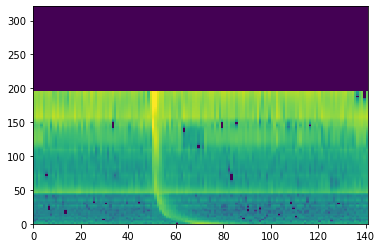

In [8]:
f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO


freq_idx_select =  np.arange(2,80,2)
t_idx = np.where(t_cur<trange[1])[0]
ds_small = ds_cur[t_idx,:]
ds_small[ds_small<1]=1
t_small = t_cur[t_idx]

plt.pcolormesh(np.log10(ds_small.T),vmin=0,vmax=5)

In [9]:
def bi_gaussian(x,x0,A,mu1,mu2,l0):
    mu =  mu1*(x<x0)+mu2*(x>=x0)
    return l0+ A* np.exp(-(x-x0)**2.0/mu**2.)

In [10]:
datatmp=ds_small[:,22]

popt, pcov = curve_fit(bi_gaussian, t_small, datatmp,
bounds=([0,np.max(datatmp)/2,1,1,np.min(datatmp)/2], 
  [np.max(t_small), np.max(datatmp)*2, np.max(t_small) ,np.max(t_small), np.mean(datatmp)]))

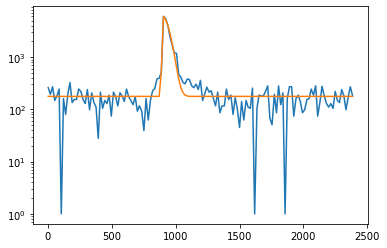

In [11]:
plt.plot(t_small,datatmp.ravel())
plt.plot(t_small,bi_gaussian(t_small,*popt))
plt.yscale('log')

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\664523972.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(t_small, f_cur,np.log10(ds_small.T),vmax=5)


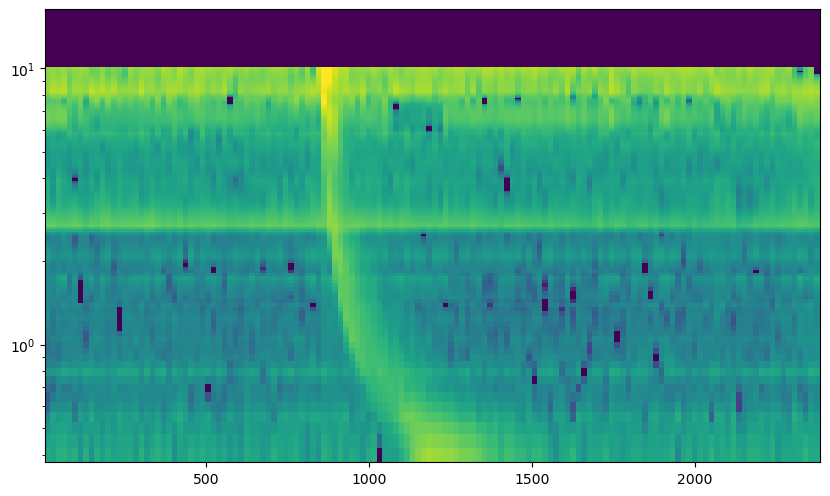

In [12]:
plt.figure(figsize=[10,6],dpi=100)
plt.pcolor(t_small, f_cur,np.log10(ds_small.T),vmax=5)
plt.yscale('log')
#plt.ylim([0.2,12])

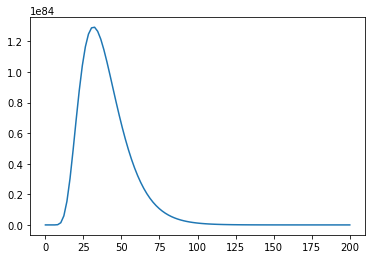

In [13]:
t =  np.linspace(0.1,200,100)
plt.plot(t,np.exp(-0.1*t-100/t+200))

In [14]:
def decay_t(x,t0,c0,c1,c2,l0):
    t = x -10.0
    return l0+ np.exp(-c0*t-c1/t+c2)

In [15]:
f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO


freq_idx_select =  np.arange(2,80,2)
t_idx = np.where(t_cur<trange[1])[0]
ds_small = ds_cur[t_idx,:]
ds_small[ds_small<1]=1
t_small = t_cur[t_idx]

peak_collect = []
peak_fit_collect = []
f_fit_collect = []
for idx in freq_idx_select:
    try:
        data_flux_curve =  ds_small[:,int(idx)]
        peak_loc = np.argmax(data_flux_curve)
        peak_collect.append(t_small[peak_loc])

        f_fit_collect.append(f_cur[idx])
    except:
        pass

    

In [16]:
popt, pcov = curve_fit(decay_t, t_small, data_flux_curve)

c:\Users\Pjer1\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [17]:


f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO
freq_idx_select =  np.arange(2,80,2)
    


def collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select):
        
    t_idx = np.where(t_cur<trange[1])[0]
    ds_small = ds_cur[t_idx,:]
    ds_small[ds_small<1]=1
    t_small = t_cur[t_idx]

    peak_collect = []
    f_fit_collect = []
    for idx in freq_idx_select:
        try:
            data_flux_curve =  ds_small[:,int(idx)]
            peak_loc = np.argmax(data_flux_curve)
            peak_collect.append(t_small[peak_loc])

            f_fit_collect.append(f_cur[idx])
        except:
            pass

    return (f_fit_collect,peak_collect,ds_small,t_small)

In [18]:
print(data_WI.shape,data_PSP.shape,data_STA.shape,data_SOLO.shape)

(881, 280) (7563, 128) (1516, 319) (3088, 321)


In [19]:


f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO
freq_idx_select =  np.arange(2,80,2)

(f_fit_collectSOLO,peak_collectSOLO,ds_smallSOLO,t_smallSOLO) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)



f_cur  = ds_f_WI
t_cur  =  ds_t_WI
ds_cur  =  data_WI
freq_idx_select =  np.arange(20,120,4)

(f_fit_collectWI,peak_collectWI,ds_smallWI,t_smallWI) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)



f_cur  = ds_f_STA
t_cur  =  ds_t_STA
ds_cur  =  data_STA
freq_idx_select =  np.arange(2,70,2)
(f_fit_collectSTA,peak_collectSTA,ds_smallSTA,t_smallSTA) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)

f_cur  = ds_f_PSP
t_cur  =  ds_t_PSP
ds_cur  =  data_PSP
freq_idx_select =  np.arange(32,100,2)

(f_fit_collectPSP,peak_collectPSP,ds_smallPSP,t_smallPSP) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)


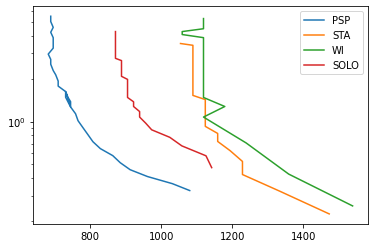

In [20]:
plt.plot(peak_collectPSP,f_fit_collectPSP,label='PSP')
plt.plot(peak_collectSTA,f_fit_collectSTA,label='STA')
plt.plot(peak_collectWI,f_fit_collectWI,label='WI')
plt.plot(peak_collectSOLO,f_fit_collectSOLO,label='SOLO')
plt.legend()
plt.yscale('log')

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\3006222665.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(t_smallPSP, ds_f_PSP,np.log10(ds_smallPSP.T),vmin=2 ,vmax=5,cmap='jet')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\3006222665.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(t_smallSTA, ds_f_STA,np.log10(ds_smallSTA.T),vmin=2 ,vmax=5,cmap='jet')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\3006222665.py:19: Matplo

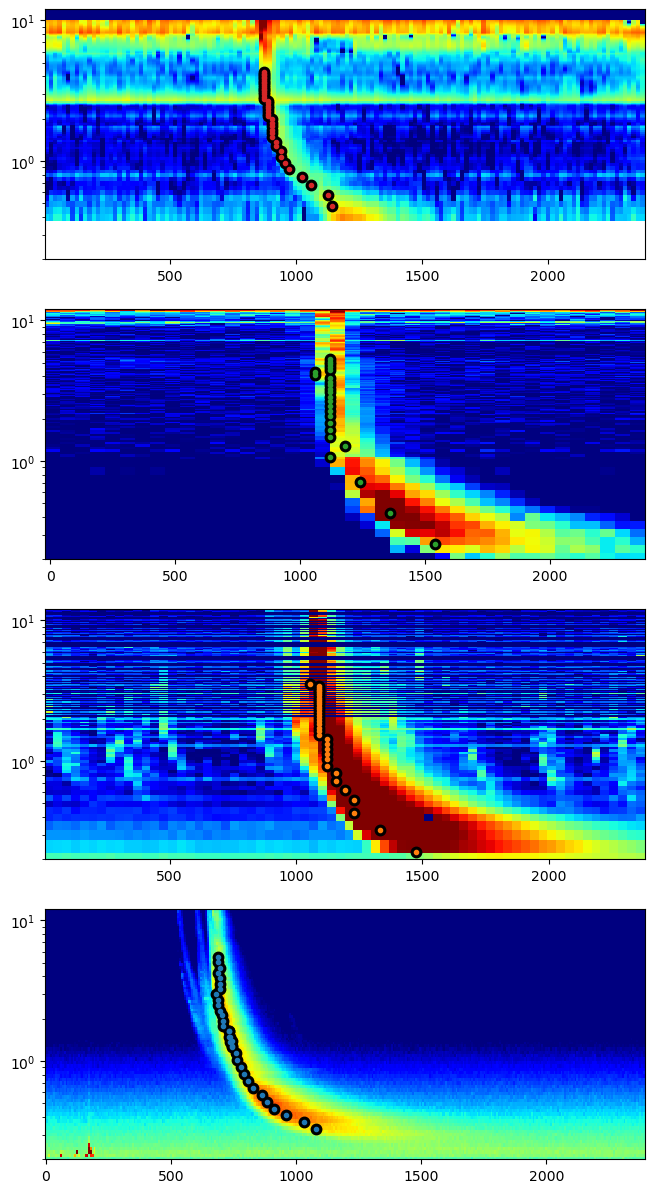

In [21]:
fig = plt.figure(figsize=[6,5],dpi=100)

ax =  fig.add_axes([0,0,1,0.5])
ax.pcolor(t_smallPSP, ds_f_PSP,np.log10(ds_smallPSP.T),vmin=2 ,vmax=5,cmap='jet')
ax.set_yscale('log')
ax.set_ylim([0.2,12])
ax.plot(peak_collectPSP,f_fit_collectPSP,'k.',ms=15)
ax.plot(peak_collectPSP,f_fit_collectPSP,'C0.')

ax =  fig.add_axes([0,0.6,1,0.5])
ax.pcolor(t_smallSTA, ds_f_STA,np.log10(ds_smallSTA.T),vmin=2 ,vmax=5,cmap='jet')
ax.set_yscale('log')
ax.set_ylim([0.2,12])
ax.plot(peak_collectSTA,f_fit_collectSTA,'k.',ms=15)
ax.plot(peak_collectSTA,f_fit_collectSTA,'C1.')


ax =  fig.add_axes([0,1.2,1,0.5])
ax.pcolor(t_smallWI, ds_f_WI,np.log10(ds_smallWI.T),vmin=2 ,vmax=5,cmap='jet')
ax.set_yscale('log')
ax.set_ylim([0.2,12])
ax.plot(peak_collectWI,f_fit_collectWI,'k.',ms=15)
ax.plot(peak_collectWI,f_fit_collectWI,'C2.')

ax =  fig.add_axes([0,1.8,1,0.5])
ax.pcolor(t_smallSOLO, ds_f_SOLO,np.log10(ds_smallSOLO.T),vmin=2 ,vmax=5,cmap='jet')
ax.set_yscale('log')
ax.set_ylim([0.2,12])
ax.plot(peak_collectSOLO,f_fit_collectSOLO,'k.',ms=15)
ax.plot(peak_collectSOLO,f_fit_collectSOLO,'C3.')




In [22]:
[t_PSP,t_STA,t_WI,t_SOLO] = [peak_collectPSP,peak_collectSTA,peak_collectWI,peak_collectSOLO]
[freq_PSP,freq_STA,freq_WI,freq_SOLO] = [np.array(x) for x in  
    [f_fit_collectPSP,f_fit_collectSTA,f_fit_collectWI,f_fit_collectSOLO]]

In [23]:
ds_f_PSP[20]

0.16640625

In [24]:
[r_STA,r_WI,r_PSP,r_SOLO] = [0.964818 ,1.014672*0.99,0.151603,0.532474]
[alpha_STA,alpha_WI,alpha_PSP,alpha_SOLO] = np.array([-71.469,0,-149.558,41.863 ]) *np.pi/180

In [25]:
# x: [t0,theta0,vs]
v_sw = 400
Min_Func = lambda x:( SEMP.Dt_STA_WI_PSP_SOLO(freq_STA*1e6,freq_WI*1e6,freq_PSP*1e6,freq_SOLO*1e6,
        t_STA,t_WI,t_PSP,t_SOLO,
        x[:,0],x[:,1],x[:,2],v_sw,alpha_STA,alpha_WI,
        alpha_PSP,alpha_SOLO,r_STA,r_WI,r_PSP,r_SOLO,
        1,1,2,3,
        Ne_par=2.0) )


In [26]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pyswarms.single.GlobalBestPSO(n_particles=50, dimensions=3,
                                    options=options,bounds=([0,-0*np.pi,0],[5000,2*np.pi,3e5]))

In [27]:

stats = optimizer.optimize(Min_Func, iters=100)

2022-11-16 14:37:47,027 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=17.3
2022-11-16 14:37:50,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17.33427192940147, best pos: [5.37969233e+02 5.19591734e+00 3.72856233e+04]


In [28]:
f_model = np.logspace(4.5,7,30)
t_model_STA = np.zeros(f_model.shape)
t_model_WI = np.zeros(f_model.shape)
t_model_PSP = np.zeros(f_model.shape)
t_model_SOLO = np.zeros(f_model.shape)

for idx,freq in enumerate(f_model):
    t_model_PSP[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_PSP,r_satellite_AU=r_PSP,Ne_par=2.0)
    t_model_STA[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_STA,r_satellite_AU=r_STA,Ne_par=2.0)
    t_model_WI[idx]  =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_WI,r_satellite_AU=r_WI,Ne_par=2.0)
    t_model_SOLO[idx]  =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_SOLO,r_satellite_AU=r_SOLO,Ne_par=2.0)

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\4031939810.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax0.pcolor(t_smallPSP, ds_f_PSP,np.log10(ds_smallPSP.T),vmin=2 ,vmax=5,cmap='jet')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\4031939810.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(t_smallSTA, ds_f_STA,np.log10(ds_smallSTA.T),vmin=2 ,vmax=5,cmap='jet')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_5060\4031939810.py:20: Matp

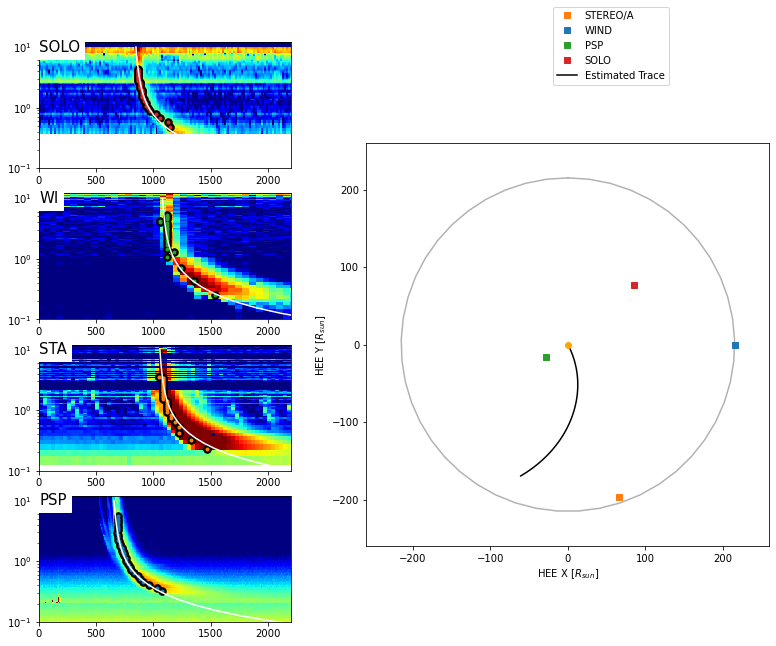

In [29]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(3.5,3.5)) 

ax0 =  fig.add_axes([0,0,1,0.5])
ax0.pcolor(t_smallPSP, ds_f_PSP,np.log10(ds_smallPSP.T),vmin=2 ,vmax=5,cmap='jet')
ax0.set_yscale('log')
ax0.set_ylim([0.1,12])
ax0.plot(peak_collectPSP,f_fit_collectPSP,'k.',ms=15)
ax0.plot(peak_collectPSP,f_fit_collectPSP,'C0.')

ax1 =  fig.add_axes([0,0.6,1,0.5])
ax1.pcolor(t_smallSTA, ds_f_STA,np.log10(ds_smallSTA.T),vmin=2 ,vmax=5,cmap='jet')
ax1.set_yscale('log')
ax1.set_ylim([0.1,12])
ax1.plot(peak_collectSTA,f_fit_collectSTA,'k.',ms=15)
ax1.plot(peak_collectSTA,f_fit_collectSTA,'C1.')


ax2 =  fig.add_axes([0,1.2,1,0.5])
ax2.pcolor(t_smallWI, ds_f_WI,np.log10(ds_smallWI.T),vmin=2 ,vmax=5,cmap='jet')
ax2.set_yscale('log')
ax2.set_ylim([0.1,12])
ax2.plot(peak_collectWI,f_fit_collectWI,'k.',ms=15)
ax2.plot(peak_collectWI,f_fit_collectWI,'C2.')

ax3 =  fig.add_axes([0,1.8,1,0.5])
ax3.pcolor(t_smallSOLO, ds_f_SOLO,np.log10(ds_smallSOLO.T),vmin=2 ,vmax=5,cmap='jet')
ax3.set_yscale('log')
ax3.set_ylim([0.1,12])
ax3.plot(peak_collectSOLO,f_fit_collectSOLO,'k.',ms=15)
ax3.plot(peak_collectSOLO,f_fit_collectSOLO,'C3.')



ax0.text(5,10,'PSP',color='k',fontsize=15,va='center',backgroundcolor='w')
ax1.text(5,10,'STA',color='k',fontsize=15,va='center',backgroundcolor='w')
ax2.text(5,10,'WI',color='k',fontsize=15,va='center',backgroundcolor='w')
ax3.text(5,10,'SOLO',color='k',fontsize=15,va='center',backgroundcolor='w')

ax0.set_xlim([0,2200])
ax1.set_xlim([0,2200])
ax2.set_xlim([0,2200])
ax3.set_xlim([0,2200])


ax0.plot(t_model_PSP,f_model/1e6,'w')
ax1.plot(t_model_STA,f_model/1e6,'w')
ax2.plot(t_model_WI,f_model/1e6,'w')
ax3.plot(t_model_SOLO,f_model/1e6,'w')

ax3 = fig.add_axes([1.3,0.3,1.6,1.6])

tmp_t = np.linspace(0,2*np.pi)
R_AU = SEMP.AU2km/SEMP.r_sun2km
r_sun2km = SEMP.r_sun2km
ax3.plot(np.sin(tmp_t)*R_AU,np.cos(tmp_t)*R_AU,'k-',alpha=0.3)
ax3.set_aspect('equal')
markWI,=ax3.plot(r_WI*np.cos(0)*R_AU,r_WI*np.sin(0)*R_AU,'s',color='C0',label='WIND')
markSTA,=ax3.plot(r_STA*np.cos(alpha_STA)*R_AU,r_STA*np.sin(alpha_STA)*R_AU,'s',color='C1',label='STEREO/A')
markPSP,=ax3.plot(r_PSP*np.cos(alpha_PSP)*R_AU,r_PSP*np.sin(alpha_PSP)*R_AU,'s',color='C2',label='PSP')
markSOLO,=ax3.plot(r_SOLO*np.cos(alpha_SOLO)*R_AU,r_SOLO*np.sin(alpha_SOLO)*R_AU,'s',color='C3',label='SOLO')

r = np.linspace(1,180,100)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r,stats[1][1],v_sw)
markSpiral,=ax3.plot(r*np.cos(theta_spiral)/r_sun2km,r*np.sin(theta_spiral)/r_sun2km,'k',label='Estimated Trace')



ax3.plot(0,0,'o',color='orange')
ax3.set_xlim([-260,260])
ax3.set_ylim([-260,260])
ax3.set_xlabel(r'HEE X [$R_{sun}$]')
ax3.set_ylabel(r'HEE Y [$R_{sun}$]')

plt.legend(handles=[markSTA,markWI,markPSP,markSOLO, markSpiral],  bbox_to_anchor=(0.45, 1.35), loc='upper left')

fig.savefig('img/combined.pdf',bbox_inches='tight')


In [30]:
stats[1][1]*180/np.pi-360

-62.29586553115848

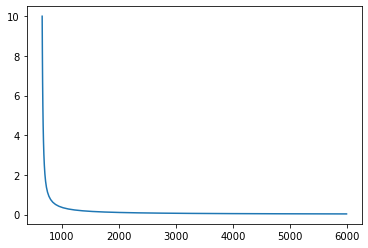

In [31]:
plt.plot(t_model_PSP,f_model/1e6)

In [52]:

r = np.linspace(1.905,46.34,20)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r,stats[1][1],v_sw)

In [53]:
theta_spiral*180/np.pi-360

array([-62.5359374 , -63.15632667, -63.77671594, -64.39710522,
       -65.01749449, -65.63788376, -66.25827303, -66.8786623 ,
       -67.49905158, -68.11944085, -68.73983012, -69.36021939,
       -69.98060866, -70.60099794, -71.22138721, -71.84177648,
       -72.46216575, -73.08255502, -73.70294429, -74.32333357])

In [54]:
r/r_sun2km

array([ 1.905     ,  4.24368421,  6.58236842,  8.92105263, 11.25973684,
       13.59842105, 15.93710526, 18.27578947, 20.61447368, 22.95315789,
       25.29184211, 27.63052632, 29.96921053, 32.30789474, 34.64657895,
       36.98526316, 39.32394737, 41.66263158, 44.00131579, 46.34      ])

In [61]:
SEMP.R_to_freq(r)

array([3.87071723, 1.73757423, 1.12022236, 0.82655227, 0.65487466,
       0.54224798, 0.46267601, 0.4034691 , 0.35769607, 0.32125062,
       0.29154525, 0.26686847, 0.24604306, 0.22823265, 0.21282668,
       0.19936904, 0.18751211, 0.17698633, 0.16757945, 0.15912206])

In [57]:
np.max(np.hstack([freq_PSP,freq_SOLO,freq_WI,freq_STA]))

5.475

In [48]:
SEMP.freq_to_R(np.max(np.hstack([freq_PSP,freq_SOLO,freq_WI,freq_STA])))/r_sun2km

array([1.90465929])

In [47]:
SEMP.freq_to_R(np.min(np.hstack([freq_PSP,freq_SOLO,freq_WI,freq_STA])))/r_sun2km

array([46.34671067])

In [51]:
np.min(np.hstack([freq_PSP,freq_SOLO,freq_WI,freq_STA]))

0.22499999403953552